# Sea Ice Comparisons to Observations



In [1]:
RUNS = {
    "b_grid": '/g/data/tm70/as2285/MOM6-CICE6-b_grid',  # (our name: run name(s))
    "c_grid": '/g/data/tm70/as2285/MOM6-CICE6-c_grid',
}

In [2]:
REF = {
    "025_OM2": "025deg_jra55_ryf9091_gadi"
}

We are going to look at Sea Ice Concentration and Sea Ice Volume

In [28]:
VARS = ["aice_m", "hi_m" ,'congel_m', 'frazil_m', 'snoice_m','dvidtt_m', 'dvidtd_m']  # ice area fraction or sea ice concentration, ice thickness averaged by grid cell area
VARS_2D = ["area_t", "geolat_t", "geolon_t", "area", "geolat", "geolon"]

**Observational Data:**

Sea Ice concentration is measured through passive microwave remote sensing. We are going to use the NSIDC CDR Dataset (described at [nsidc.org](https://nsidc.org/data/g02202/versions/4))

In [4]:
OBS_TIME_SLICE = slice("1979", "2022")
sh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday"
nh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday"

**Load depenencies:**

In [5]:
from intake import open_esm_datastore
from intake import cat
from datatree import DataTree, map_over_subtree

from dask.distributed import Client

import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:92: VersionWarning: ESMF installation version 8.6.0, ESMPy version 8.6.1
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [6]:
catalog = cat.access_nri

A standard way to calculate climatologies. (We start in 1991 as earlier decades are influenced by model spin-up for 0.25deg runs which only start in 1980.)

In [7]:
OBS_TIME_SLICE = slice("1990-05", "1991-04")


def climatology(ds):
    "only for model data, drop the first 10 years for spinup"
    return ds.isel(time=slice(10,None)).groupby("time.month").mean("time")#.sel(time=CLIMAT_TIME_SLICE)

Start a dask client

In [8]:
client = Client(threads_per_worker=1)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46865,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:43773,Total threads: 1
Dashboard: /proxy/45109/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:40297,


In [9]:
@map_over_subtree
def year_min(ds):
    return ds.groupby('time.year').min()

@map_over_subtree
def year_max(ds):
    return ds.groupby('time.year').max()

# Load the ACCESS-OM2 results

For CICE data in OM2, we need to do some wrangling to make it easier to deal with. This is described in more detail in [DocumentedExamples/SeaIce_Plot_Example](https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/SeaIce_Plot_Example.html). Its included in this function:

In [10]:
ds_pairs=dict([(iRun, (
        open_esm_datastore(
            RUNS[iRun] + '/intake_datastore.json',
            columns_with_iterables=["variable"] 
        ))) for iRun in RUNS])

In [11]:
ds_pairs['b_grid'].search(variable='aice').df

,path,realm,variable,frequency,start_date,end_date,variable_long_name,variable_standard_name,variable_cell_methods,variable_units,filename,file_id
0,/g/data/tm70/as2285/MOM6-CICE6-b_grid/output000/access-om3.cice.h.1900-01-daily.nc,seaIce,"[time_bounds, NCAT, VGRDi, VGRDs, VGRDb, VGRDa, blkmask, ANGLE, ANGLET, hi, hs, aice, uvel, vvel, frzmlt, congel, frazil, snoice, dvidtt, dvidtd, sifb]",1day,"1900-01-01, 00:00:00","1900-02-01, 00:00:00","['time interval endpoints', 'category maximum thickness', 'vertical ice levels', 'vertical snow levels', 'vertical ice-bio levels', 'vertical snow-ice-bio levels', 'ice grid block mask, mytask + i...","['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']","['time: mean', '', '', '', '', '', '', '', '', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: me...","['days since 1900-01-01 00:00:00', 'm', '1', '1', '1', '1', 'unitless', 'radians', 'radians', 'm', 'm', '1', 'm/s', 'm/s', 'W/m^2', 'cm/day', 'cm/day', 'cm/day', 'cm/day', 'cm/day', 'm']",access-om3.cice.h.1900-01-daily.nc,access_om3_cice_h_1900_01_daily
1,/g/data/tm70/as2285/MOM6-CICE6-b_grid/output000/access-om3.cice.h.1900-02-daily.nc,seaIce,"[time_bounds, NCAT, VGRDi, VGRDs, VGRDb, VGRDa, blkmask, ANGLE, ANGLET, hi, hs, aice, uvel, vvel, frzmlt, congel, frazil, snoice, dvidtt, dvidtd, sifb]",1day,"1900-02-01, 00:00:00","1900-03-01, 00:00:00","['time interval endpoints', 'category maximum thickness', 'vertical ice levels', 'vertical snow levels', 'vertical ice-bio levels', 'vertical snow-ice-bio levels', 'ice grid block mask, mytask + i...","['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']","['time: mean', '', '', '', '', '', '', '', '', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: me...","['days since 1900-01-01 00:00:00', 'm', '1', '1', '1', '1', 'unitless', 'radians', 'radians', 'm', 'm', '1', 'm/s', 'm/s', 'W/m^2', 'cm/day', 'cm/day', 'cm/day', 'cm/day', 'cm/day', 'm']",access-om3.cice.h.1900-02-daily.nc,access_om3_cice_h_1900_02_daily
2,/g/data/tm70/as2285/MOM6-CICE6-b_grid/output000/access-om3.cice.h.1900-03-daily.nc,seaIce,"[time_bounds, NCAT, VGRDi, VGRDs, VGRDb, VGRDa, blkmask, ANGLE, ANGLET, hi, hs, aice, uvel, vvel, frzmlt, congel, frazil, snoice, dvidtt, dvidtd, sifb]",1day,"1900-03-01, 00:00:00","1900-04-01, 00:00:00","['time interval endpoints', 'category maximum thickness', 'vertical ice levels', 'vertical snow levels', 'vertical ice-bio levels', 'vertical snow-ice-bio levels', 'ice grid block mask, mytask + i...","['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']","['time: mean', '', '', '', '', '', '', '', '', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: me...","['days since 1900-01-01 00:00:00', 'm', '1', '1', '1', '1', 'unitless', 'radians', 'radians', 'm', 'm', '1', 'm/s', 'm/s', 'W/m^2', 'cm/day', 'cm/day', 'cm/day', 'cm/day', 'cm/day', 'm']",access-om3.cice.h.1900-03-daily.nc,access_om3_cice_h_1900_03_daily
3,/g/data/tm70/as2285/MOM6-CICE6-b_grid/output000/access-om3.cice.h.1900-04-daily.nc,seaIce,"[time_bounds, NCAT, VGRDi, VGRDs, VGRDb, VGRDa, blkmask, ANGLE, ANGLET, hi, hs, aice, uvel, vvel, frzmlt, congel, frazil, snoice, dvidtt, dvidtd, sifb]",1day,"1900-04-01, 00:00:00","1900-05-01, 00:00:00","['time interval endpoints', 'category maximum thickness', 'vertical ice levels', 'vertical snow levels', 'vertical ice-bio levels', 'vertical snow-ice-bio levels', 'ice grid block mask, mytask + i...","['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']","['time: mean', '', '', '', '', '', '', '', '', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'time: mean', 'ti

In [12]:
ds_pairs

{'b_grid': <intake_datastore catalog with 605 dataset(s) from 3010 asset(s)>,
 'c_grid': <intake_datastore catalog with 606 dataset(s) from 6660 asset(s)>}

In [66]:
def open_by_experiment_om2(ds, vars):
    """Concatenate any datasets provided for this experiment into one ds, and add area and geo coordinates"""

    # get the data for each run of this config
    cice_ds = ds.search(variable=vars).to_dask(
            xarray_combine_by_coords_kwargs={
                "compat": "override",
                "data_vars": "minimal",
                "coords": "minimal",
            },
        )

    # cice timestamps are also misleading:
    cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)
    
    cice_ds = cice_ds.sel(time=slice('1900','1950'))
    
    # We also want the area/lat/lon fields, but these are not time dependent.
    # This is slightly dodge loading them from MOM, because they can be not exact matches to CICE. MOM5 uses area_t ... and MOM6 uses area for the same var
    area_ds = xr.open_dataset(
        ds.search(variable=["area_t", "geolat_t", "geolon_t", "area", "geolat", "geolon"]).df.path[0]
    )

    # Label the lats and lons
    cice_ds.coords["ni"] = area_ds["xt_ocean"].values
    cice_ds.coords["nj"] = area_ds["yt_ocean"].values

    # Copy attributes for cf compliance
    cice_ds.ni.attrs = area_ds.xt_ocean.attrs
    cice_ds.nj.attrs = area_ds.yt_ocean.attrs

    cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))

    # Add the geolon, geolat, and area as extra co-ordinates fields from area_t

    cice_ds = cice_ds.assign_coords(
        {
            "geolat_t": area_ds.geolat_t,
            "geolon_t": area_ds.geolon_t,
            "area_t": area_ds.area_t,
        }
    )
    


    return cice_ds

In [14]:
def open_by_experiment_om3(ds, vars):
    """Concatenate any datasets provided for this experiment into one ds, and add area and geo coordinates"""

    # get the data for each run of this config
    cice_ds = ds.search(variable=vars).to_dask(
            xarray_combine_by_coords_kwargs={
                "compat": "override",
                "data_vars": "minimal",
                "coords": "minimal",
            },
        )

    # We also want the area/lat/lon fields, but these are not time dependent.
    # This is slightly dodge loading them from MOM, because they can be not exact matches to CICE. MOM5 uses area_t ... and MOM6 uses area for the same var
    area_ds = xr.open_dataset(
        ds.search(variable=["area_t", "geolat_t", "geolon_t", "area", "geolat", "geolon"]).df.path[0]
    )
    # xr.open_dataset(
    #             '/g/data/vk83/experiments/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc', 
    #             decode_coords=False
    #         )

    # Label the lats and lons
    cice_ds.coords["ni"] = area_ds["xh"].values
    cice_ds.coords["nj"] = area_ds["yh"].values

    # Copy attributes for cf compliance
    cice_ds.ni.attrs = area_ds.xh.attrs
    cice_ds.nj.attrs = area_ds.yh.attrs

    cice_ds = cice_ds.rename(({"ni": "xh", "nj": "yh"}))

    # Add the geolon, geolat, and area as extra co-ordinates fields from area_t

    cice_ds = cice_ds.assign_coords(
        {
            "geolat_t": area_ds.geolat,
            "geolon_t": area_ds.geolon,
            "area_t": area_ds.areacello,
        }
    )

    return cice_ds

Because the dimensions are different for different experiments, they would not fit in a Dataset, a DataTree is required. The DataTree has a group for each experiment, which contains a xarray dataset with the data for that experiment. 

In [67]:
%%time

si_name_ds_pairs = [(iRun, open_by_experiment_om3(ds_pairs[iRun], VARS)) for iRun in RUNS.keys()]

CPU times: user 13.1 s, sys: 736 ms, total: 13.9 s
Wall time: 22.5 s


In [68]:
si_name_ds_pairs.append(("025_OM2",open_by_experiment_om2(catalog[REF["025_OM2"]], VARS)))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 48.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [69]:
si_dt = DataTree.from_dict(dict(si_name_ds_pairs))

In [70]:
@map_over_subtree
def match_timestamps_to_CDR(ds):
    cice_ds = ds.copy()

    # we are going to use the same timestamps as NSIDC
    cice_ds["time"] = [
        np.datetime64(str(i)[0:7] + "-01T00:00:00.000000000")
        for i in cice_ds.time.values
    ]

    return cice_ds

In [71]:
si_dt = match_timestamps_to_CDR(si_dt)

The result is a datatree, with a dataset for each experiment and timestamps which align with the observational timestamps

# Load the observational dataset

The CDR dataset has the area of each grid cell provided as a seperate file, which we need to load

In [52]:
def open_cdr_dataset(path, area_file):
    ds = xr.open_dataset(path).rename(
        {'cdr_seaice_conc_monthly': 'cdr_conc', 'xgrid':'x','ygrid':'y'}
    )

    # # we also need the area of each gridcell
    areasNd = np.fromfile(area_file, dtype=np.int32).reshape(
        ds.cdr_conc.isel(time=0).shape
    )
    # # Divide by 1000 to get km2 (https://web.archive.org/web/20170817210544/http://nsidc.org/data/polar-stereo/tools_geo_pixel.html#pixel_area)
    areasKmNd_sh = areasNd / 1000
        
    ds["area"] = xr.DataArray(areasKmNd_sh, dims=["y", "x"])
    ds = ds.set_coords("area")

    ds = ds.cdr_conc
    ds = ds.where(ds<=1)  # convert error codes to Nan

    return ds

We can pull the datasets direct from the url, however the cell area needs to be downloaded seperately:

In [53]:
!wget --ftp-user=anonymous -nc ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/psn25area_v3.dat

File ‘pss25area_v3.dat’ already there; not retrieving.
File ‘psn25area_v3.dat’ already there; not retrieving.


We are interested in the Antarctic, but the lines for the Arctic are below and commented out.

In [54]:
sh_cdr_xr = open_cdr_dataset(sh_obs_url, "pss25area_v3.dat")

nh_cdr_xr = open_cdr_dataset(
    nh_obs_url,
    'psn25area_v3.dat'
)

cdr_dt = DataTree.from_dict(
    {
        "cdr_sh": sh_cdr_xr,
        'cdr_nh':nh_cdr_xr
    }
)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'melt_onset_day_cdr_seaice_conc_monthly' has multiple fill values {-1, 255} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


The result is a datatree, with a datasets for the relevant hemisphere

# Calculate Sea Ice Area

Sea ice area is the circumpolar sum of sea ice concentration multiplied by the area of each grid cell. By convention, and because lower concentrations are not accurate when measured through remote sensing, concentrations below 0.15 are not included

In [55]:
def sea_ice_area(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

Calculate for observational data, and remove gaps with missing data

In [56]:
@map_over_subtree
def sea_ice_area_obs(ds):
    sic = ds.cdr_conc
    result = sea_ice_area(sic, sic.area).to_dataset(name="cdr_area")

    # Theres a couple of data gaps which should be nan
    result.loc[{"time": "1988-01-01"}] = np.nan
    result.loc[{"time": "1987-12"}] = np.nan

    return result.sel(time=OBS_TIME_SLICE)

In [57]:
obs_area_dt = sea_ice_area_obs(cdr_dt)

Calculate for model data, limit to southern hemisphere / Antarctica

In [58]:
@map_over_subtree
def sea_ice_area_model(ds):

    sia_total_ds = xr.Dataset()
    
    sic = ds.aice_m.cf.sel(Y=slice(-90, 0))
    area_km2 = ds.area_t / 1e6

    sia_total_ds['sh'] = sea_ice_area(sic, area_km2)

    sic = ds.aice_m.cf.sel(Y=slice(0, 90))
    area_km2 = ds.area_t / 1e6

    sia_total_ds['nh'] = sea_ice_area(sic, area_km2)

    return sia_total_ds

In [59]:
model_area_dt = sea_ice_area_model(si_dt)

# Sea Ice Area Trends

We are going to compare the trends in the minima and maxima over time, and the monthly climatology

In [60]:
min_area_dt = year_min(model_area_dt)
max_area_dt = year_max(model_area_dt)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

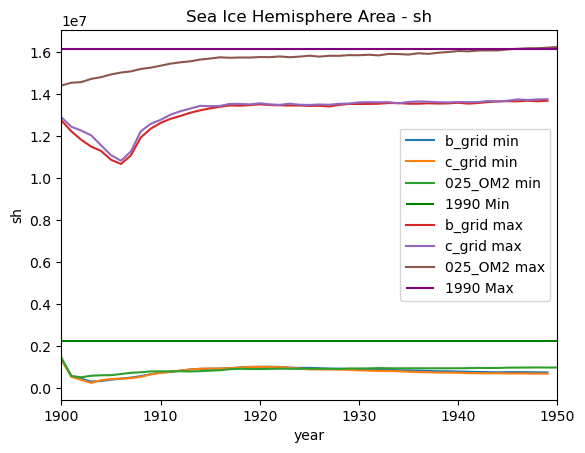

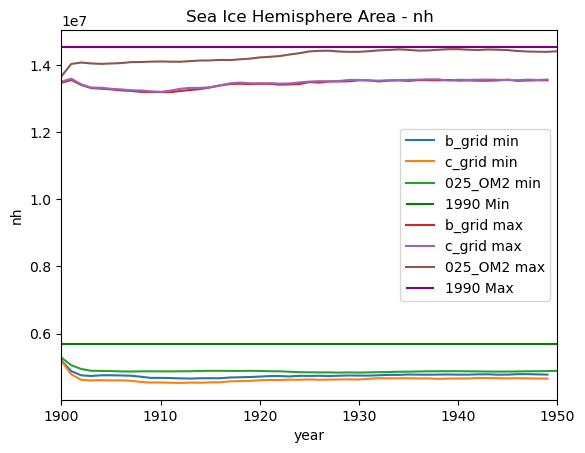

In [61]:
for iVar in ['sh','nh']:
    plt.figure()

    for iGroup in min_area_dt.groups[1:]:
        min_area_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' min')

    plt.hlines(
        obs_area_dt["cdr_"+iVar].ds.cdr_area.sel(time=OBS_TIME_SLICE).min(),
        1900, 1950,
        color = 'green',
        label = '1990 Min'
    )
    
    for iGroup in max_area_dt.groups[1:]:
        max_area_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' max')

    plt.hlines(
        obs_area_dt["cdr_"+iVar].ds.cdr_area.sel(time=OBS_TIME_SLICE).max(),
        1900, 1950,
        color = 'purple',
        label = '1990 Max'
    )

    plt.xlim([1900,1950])
    plt.title("Sea Ice Hemisphere Area - " + iVar)
    _ = plt.legend()


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, re

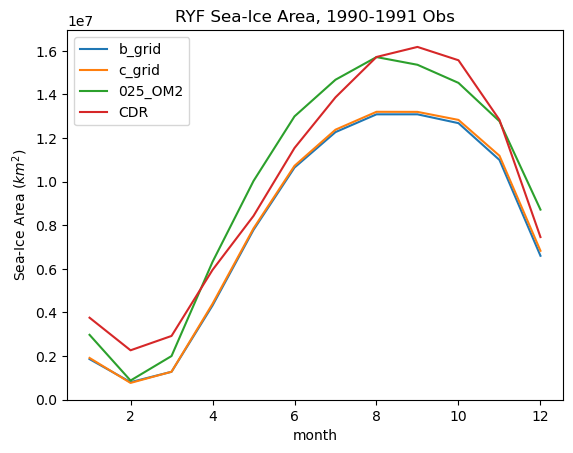

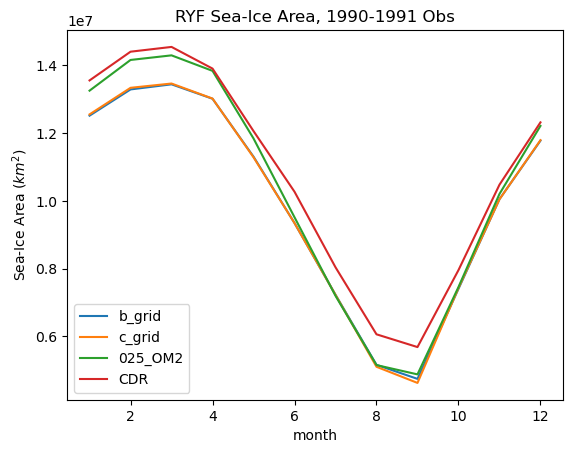

In [62]:
for iVar in ['sh','nh']:
    plt.figure()
    
    for iGroup in model_area_dt.groups[1:]:
        climatology(model_area_dt[iGroup].ds[iVar]).plot(label=iGroup[1:])

    (obs_area_dt["cdr_"+iVar].ds.sel(time=OBS_TIME_SLICE).groupby('time.month').mean('time').cdr_area).plot(label="CDR")

    plt.title("RYF Sea-Ice Area, 1990-1991 Obs")
    plt.ylabel("Sea-Ice Area ($km^2$)")
    
    _ = plt.legend()

In [63]:
@map_over_subtree
def plot_last_feb_sep(ds):
    ds.where(ds.time.dt.month==2, drop=True).isel(time=-1).aice_m.plot.contour(levels=[0.8])
    return ds

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2001: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contour(x, y, z, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2001: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contour(x, y, z, **kwargs)


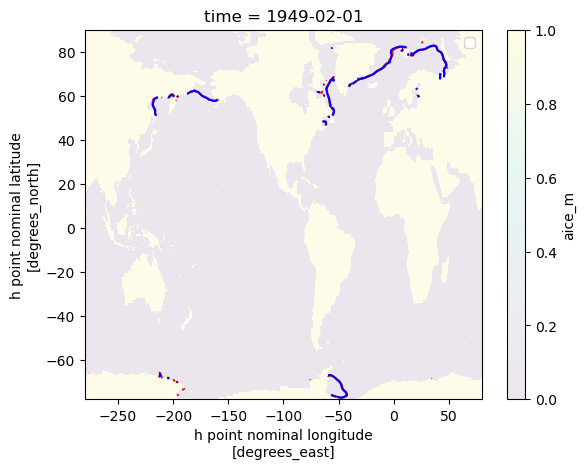

In [64]:
si_dt['b_grid'].ds.isel(time=-1).aice_m.isnull().plot(alpha=0.1)


ds = si_dt['b_grid'].ds
ds.where(ds.time.dt.month==2, drop=True).isel(time=-1).aice_m.plot.contour(levels=[0.8], colors=['r'], label='b_grid')

ds = si_dt['c_grid'].ds
ds.where(ds.time.dt.month==2, drop=True).isel(time=-1).aice_m.plot.contour(levels=[0.8], colors=['b'], label='c_grid')

plt.legend(labels=['b_grid','c_grid'])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2001: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contour(x, y, z, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2001: UserWarning: The following kwargs were not used by contour: 'label'
  primitive = ax.contour(x, y, z, **kwargs)


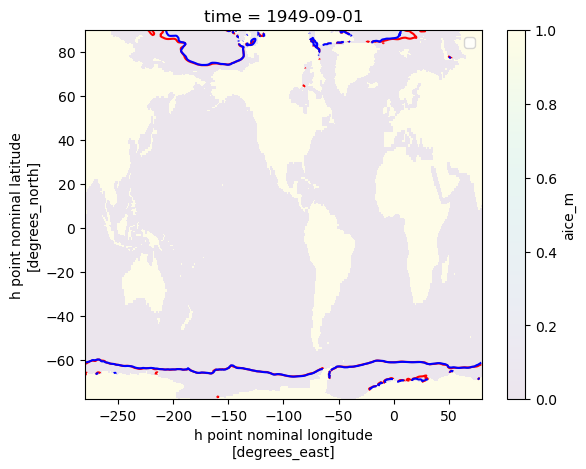

In [65]:
si_dt['b_grid'].ds.isel(time=-1).aice_m.isnull().plot(alpha=0.1)


ds = si_dt['b_grid'].ds
ds.where(ds.time.dt.month==9, drop=True).isel(time=-1).aice_m.plot.contour(levels=[0.8], colors=['r'], label='b_grid')

ds = si_dt['c_grid'].ds
ds.where(ds.time.dt.month==9, drop=True).isel(time=-1).aice_m.plot.contour(levels=[0.8], colors=['b'], label='c_grid')

plt.legend(labels=['b_grid','c_grid'])

To examine the differences between the model results and observations, we calculate difference in each grid cell between observations and each experiment

As that data are on different grids, we need to regrid to compare the datasets

Lets simplify a little to only look at 0.25 degree results

The lat/lon of of each cell in the observational dataset are in a different file:

We can now build the re-gridder. This is described in detail in [DocumentedExamples/Regridding](https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/Regridding.html)

We can now plot the difference between modelled and observed sea ice concentration

We see that OM2 under-represents sea ice in Summer, particularly in the Weddell Sea. In Winter, trends are less clear, although ERA5 forced sea ice concentration is too high at the northern boundary.

# Sea Ice Volume

In [20]:
@map_over_subtree
def sea_ice_vol_model(ds):

    siv_total_ds = xr.Dataset()
    
    vice_m = ds.hi_m.cf.sel(Y=slice(-90, 0))
    siv_total_ds['sh'] = (
        (vice_m * ds.area_t)
        .where(~np.isnan(ds.area_t))
        .cf.sum(["X", "Y"])
    )

    vice_m = ds.hi_m.cf.sel(Y=slice(0,90))
    siv_total_ds['nh'] = (
        (vice_m * ds.area_t)
        .where(~np.isnan(ds.area_t))
        .cf.sum(["X", "Y"])
    )

    return siv_total_ds

In [21]:
si_vol_dt = sea_ice_vol_model(si_dt)

In [22]:
min_vol_dt = year_min(si_vol_dt)
max_vol_dt = year_max(si_vol_dt)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

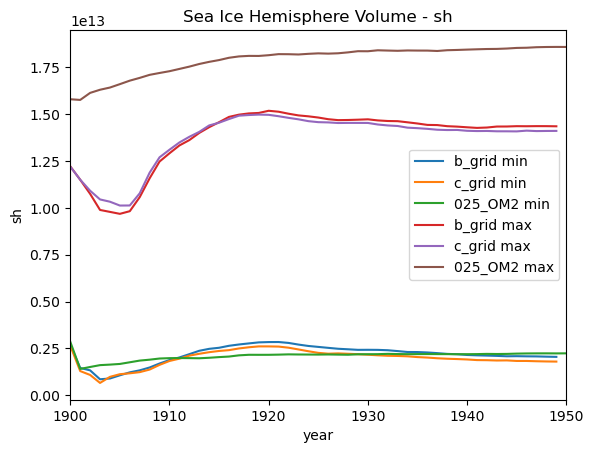

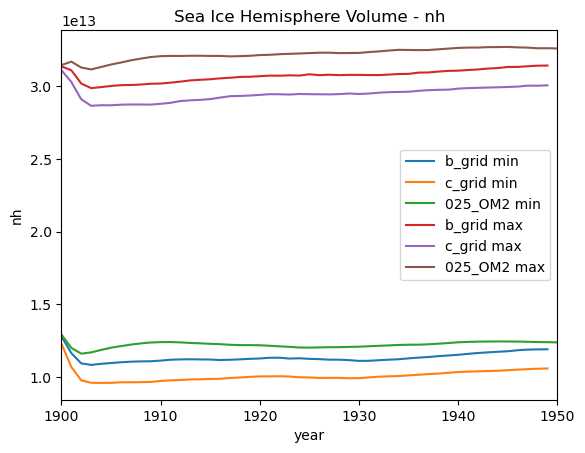

In [23]:
for iVar in ['sh','nh']:
    plt.figure()

    for iGroup in min_vol_dt.groups[1:]:
        min_vol_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' min')
    
    for iGroup in max_vol_dt.groups[1:]:
        max_vol_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' max')

    plt.xlim([1900,1950])
    plt.title("Sea Ice Hemisphere Volume - " + iVar)
    _ = plt.legend()



INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, re

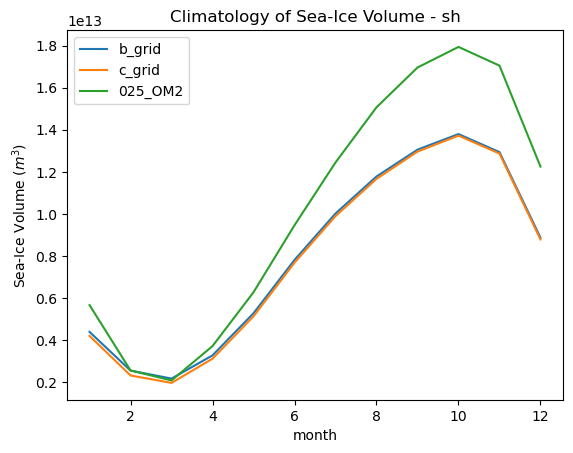

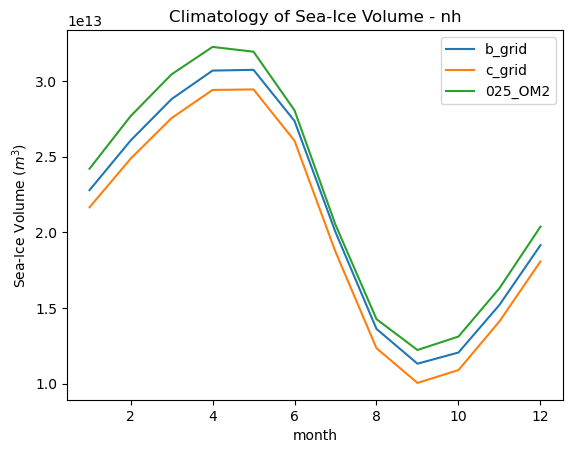

In [24]:
for iVar in ['sh','nh']:
    plt.figure()

    for iGroup in si_vol_dt.groups[1:]:
        climatology(
            si_vol_dt[iGroup].ds[iVar]
        ).plot(label=iGroup[1:])

    plt.title("Climatology of Sea-Ice Volume - "+iVar)
    plt.ylabel("Sea-Ice Volume ($m^3$)")
    _ = plt.legend()
    

In [41]:
si_dt['c_grid']

DataTree('c_grid', parent="None")
    Dimensions:   (time: 600, yh: 300, xh: 360)
    Coordinates:
      * time      (time) datetime64[ns] 5kB 1900-01-01 1900-02-01 ... 1949-12-01
      * xh        (xh) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
      * yh        (yh) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
        geolat_t  (yh, xh) float32 432kB ...
        geolon_t  (yh, xh) float32 432kB ...
        area_t    (yh, xh) float32 432kB ...
    Data variables:
        dvidtd_m  (time, yh, xh) float64 518MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
        congel_m  (time, yh, xh) float64 518MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
        hi_m      (time, yh, xh) float64 518MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
        frazil_m  (time, yh, xh) float64 518MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
        dvidtt_m  (time, yh, xh) float64 518MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
        aice_m    (time, yh, xh) float64 518MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
        snoice_m  (time, yh, xh) float64 518MB dask.array<chunksize=(1, 150, 180), meta=np.ndarray>
    Attributes: (12/20)
        title:                                    access-om3
        contents:                                 Diagnostic and Prognostic Varia...
        source:                                   CICE Sea Ice Model, unknown_ver...
        comment:                                  All years have exactly 365 days
        comment3:                                 seconds elapsed into model date...
        time_period_freq:                         month_1
        ...                                       ...
        intake_esm_attrs:variable_standard_name:  ['', '', '', '', '', '', '', ''...
        intake_esm_attrs:variable_cell_methods:   ['', '', '', '', '', '', '', ''...
        intake_esm_attrs:variable_units:          ['days since 1900-01-01 00:00:0...
        intake_esm_attrs:file_id:                 access_om3_cice_h_XXXX_XX
        intake_esm_attrs:_data_format_:           netcdf
        intake_esm_dataset_key:                   access_om3_cice_h_XXXX_XX.1mon

In [47]:
list(si_dt.keys())

['b_grid', 'c_grid', '025_OM2']

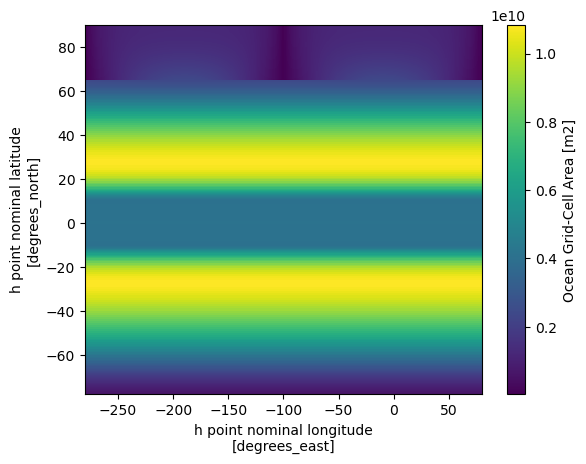

In [73]:
si_dt['b_grid'].ds.area_t.plot()

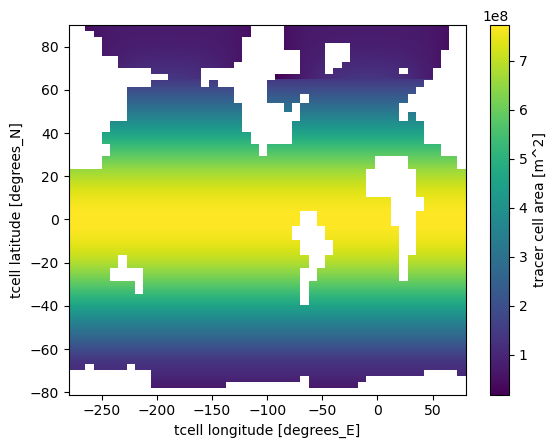

In [74]:
si_dt['025_OM2'].ds.area_t.plot()

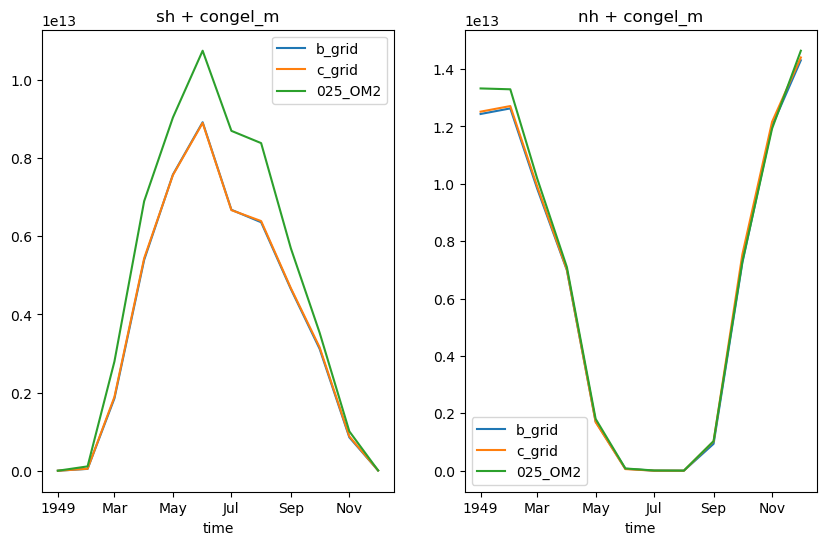

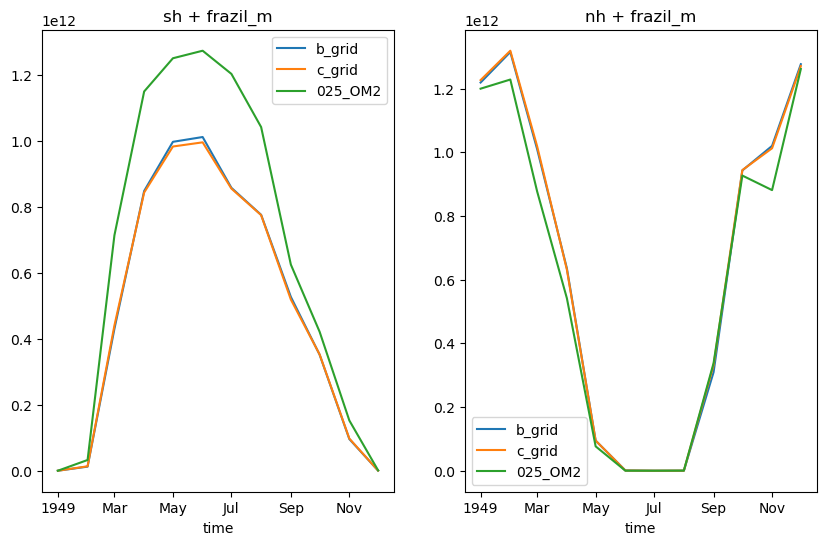

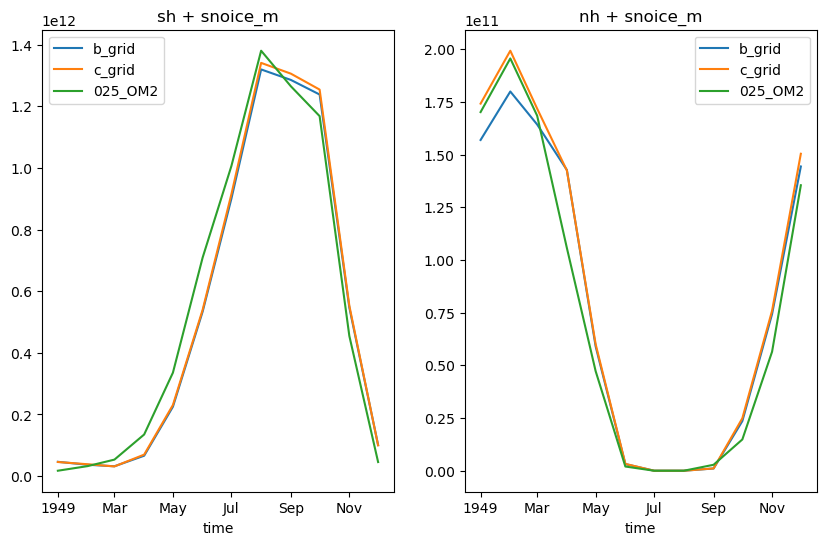

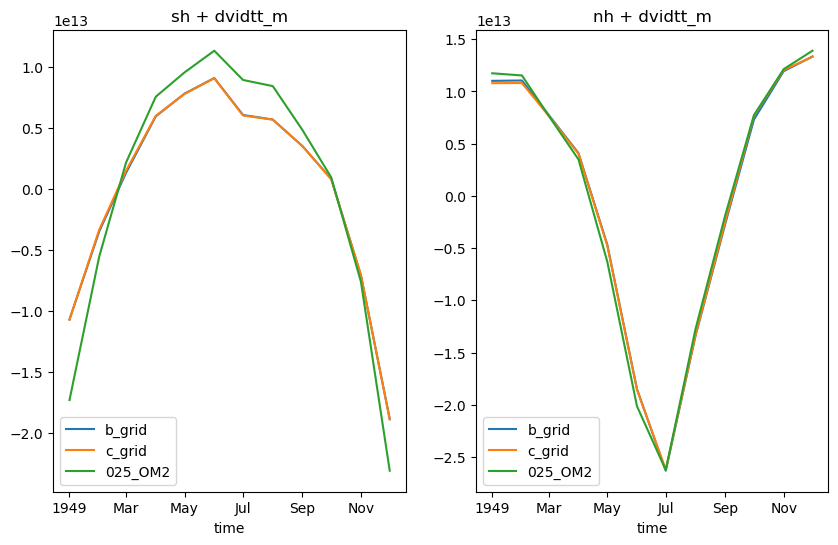

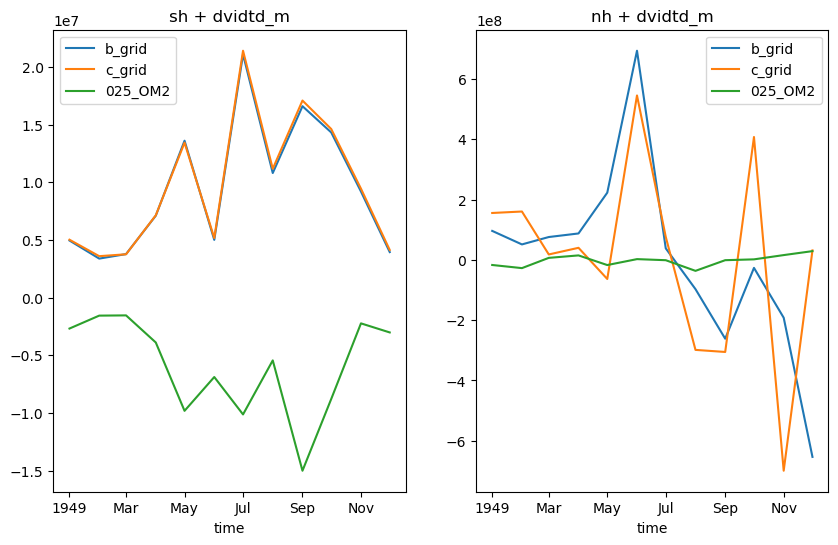

In [76]:

for var in ['congel_m', 'frazil_m', 'snoice_m','dvidtt_m', 'dvidtd_m']:

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    for key in si_dt.keys():
        ds = si_dt[key].ds
        ds_vol = ds[var]*ds.area_t.where(~np.isnan(ds.area_t))
        ds_vol.cf.sel(Y=slice(-90, 0),time=slice("1949","1949")).cf.sum(['X','Y']).plot(label=key)
    plt.legend()
    plt.title(f"sh + {var}")
    
    plt.subplot(1,2,2)
    for key in si_dt.keys():
        ds = si_dt[key].ds
        ds_vol = ds[var]*ds.area_t.where(~np.isnan(ds.area_t))
        ds_vol.cf.sel(Y=slice(0, 90),time=slice("1949","1949")).cf.sum(['X','Y']).plot(label=key)
    plt.legend()
    plt.title(f"nh + {var}")

In [27]:
ds_pairs['b_grid'].search(frequency="1mon").df.variable[0]

['time_bounds',
 'NCAT',
 'VGRDi',
 'VGRDs',
 'VGRDb',
 'VGRDa',
 'blkmask',
 'ANGLE',
 'ANGLET',
 'hi_m',
 'hs_m',
 'Tsfc_m',
 'aice_m',
 'uvel_m',
 'vvel_m',
 'uatm_m',
 'vatm_m',
 'sice_m',
 'fswup_m',
 'fswdn_m',
 'flwdn_m',
 'snow_ai_m',
 'rain_ai_m',
 'frzmlt_m',
 'scale_factor_m',
 'fswabs_ai_m',
 'albsni_m',
 'alvdr_ai_m',
 'alidr_ai_m',
 'alvdf_ai_m',
 'alidf_ai_m',
 'albice_m',
 'albsno_m',
 'flat_ai_m',
 'fsens_ai_m',
 'flwup_ai_m',
 'evap_ai_m',
 'Tair_m',
 'congel_m',
 'frazil_m',
 'snoice_m',
 'meltt_m',
 'melts_m',
 'meltb_m',
 'meltl_m',
 'fresh_ai_m',
 'fsalt_m',
 'fsalt_ai_m',
 'fhocn_ai_m',
 'fswthru_ai_m',
 'strairx_m',
 'strairy_m',
 'strtltx_m',
 'strtlty_m',
 'strcorx_m',
 'strcory_m',
 'strocnx_m',
 'strocny_m',
 'strintx_m',
 'strinty_m',
 'strength_m',
 'divu_m',
 'shear_m',
 'vort_m',
 'dvidtt_m',
 'dvidtd_m',
 'daidtt_m',
 'daidtd_m',
 'trsig_m',
 'ice_present_m',
 'fcondtop_ai_m',
 'fmeltt_ai_m',
 'sifb_m',
 'opening_m',
 'aicen_m',
 'vicen_m',
 'fsurfn_ai_

In [ ]:
'congel_m',
 'frazil_m',
 'snoice_m','dvidtt_m',
 'dvidtd_m',

In [92]:
client.close()